# Let's play with some NBA data!

- The data set includes play-by-play for every regular season game from 2001 to 2018 and was downloaded [here](https://eightthirtyfour.com/).

- My goal here is to understand the causes and effects of coach timeouts by analyzing the scores of adjacent minutes.

# Open data by season

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
# import mpld3
# from mpld3 import plugins

season = '2017-18'

filename = 'C:/Users/Zaca/Dropbox/data_science/{season}_pbp.csv'.format(season=season)

data = pd.read_csv(filename, usecols=['GAME_ID', 'HOMEDESCRIPTION', 'PCTIMESTRING', 'PERIOD', 'SCORE', 'VISITORDESCRIPTION'])

# Here we are just print all the column names in our data file. 
# We are only interested in a few of them such as: GAME_ID, HOMEDESCRIPTION, PCTIMESTRING, PERIOD, SCORE, VISITORDESCRIPTION

print(list(data))


# Here I'm just checking to see the total of unique game IDs in each season file. 
# The total games in a season (non lockout) is 1230. Each of the 30 NBA teams play 82 games in a season: (30*82)/2
# Divided by two because there are two teams involved in each game.

game_count = np.unique(data['GAME_ID'])
print(len(game_count))


['GAME_ID', 'HOMEDESCRIPTION', 'PCTIMESTRING', 'PERIOD', 'SCORE', 'VISITORDESCRIPTION']
1230


# Do some data cleaning.
- Change time left in quarter to seconds for one.

In [4]:
def convert_time(times):
    mins, secs = map(int, times.split(':'))
    return 60*mins + secs

data['PCTIMESTRING'] = data['PCTIMESTRING'].apply(convert_time)

data['GLOBALTIMELEFT'] = data['PCTIMESTRING'] + (720*(4-data['PERIOD'].clip(upper=4)))

- The SCORE and SCOREMARGIN columns are only updated in the raw data when there is a bucket. I'm going to fill those columns up.

In [5]:
# I want to clean up the score column so it is more accessible.

temp_score = data['SCORE'].fillna(method='ffill').replace(np.nan, '0 - 0')
temp_score = temp_score.str.split(" - ", expand=True).astype('int32')

data['HOMESCORE'] = temp_score[1]
data['VISITORSCORE'] = temp_score[0]
data['SCOREMARGIN'] = data['HOMESCORE'] - data['VISITORSCORE']

data = data.drop(columns=['SCORE'])



# Isolating timeouts

- To do some very simple analysis, I will select only the rows when a timeout happened and we can check what the score was, for example.
- So for now, let's just look at the distribution of timeouts by period and time left in the period.
- The identity of the team asking for the timeout is not really relevant for this early analysis.

13234


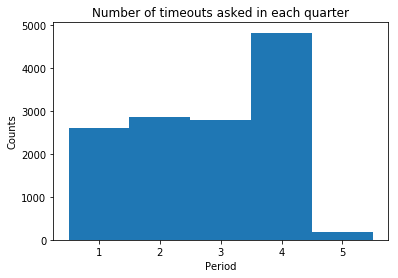

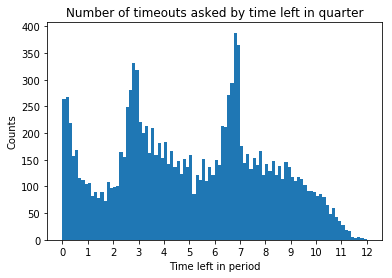

In [6]:
# We can use vectorized string methods to filter (http://pandas.pydata.org/pandas-docs/stable/user_guide/text.html) our dataframe by partial string match.

timeouts = data.loc[(data['HOMEDESCRIPTION'].str.contains("Timeout", na=False)) | (data['VISITORDESCRIPTION'].str.contains("Timeout", na=False))]
print(len(timeouts))

bins = np.linspace(1, 6, num=6)


# Plot timeouts by period.
plt.figure()
plt.title('Number of timeouts asked in each quarter')
plt.xlabel('Period')
plt.ylabel('Counts')
plt.xticks(bins + 0.5, range(1, 6))
plt.hist(np.clip(timeouts['PERIOD'], bins[0], bins[-1]), bins);


# Plot timeouts by time left in period.
plt.figure()
plt.title('Number of timeouts asked by time left in quarter')
plt.xlabel('Time left in period')
plt.ylabel('Counts')
plt.xticks(np.linspace(0, 720, num=13), range(0, 13))
plt.hist(timeouts['PCTIMESTRING'], bins= 96);


- Let's try and get the frequency of timeouts over time. 
- For this we need to take into account which period we're on, and transform the time left in quarter into time left in game.

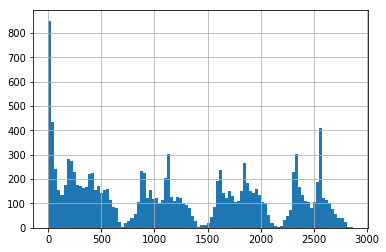

In [7]:
timeouts['GLOBALTIMELEFT'].hist(bins=100)

# Interactive plots

- Bokeh does not have a built-in histogram glyph, but we can make our own using the quad glyph which allows us to specify the bottom, top, left, and right edges of each bar.

- To create the data for the bars, we will use the numpy histogram function which calculates the number of data points in each specified bin.

In [8]:
from bokeh.plotting import figure
from bokeh.io import show, output_notebook, output_file
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool
from bokeh.resources import CDN
from bokeh.embed import file_html

# We clip the data so every timeout after the 4th is considered into the same window "OT"
arr_hist, edges = np.histogram(timeouts['PERIOD'].clip(upper=5), bins=5, range=(1, 6))

# Put the information in a dataframe
timeout_periods = pd.DataFrame({'period': arr_hist, 'left': edges[:-1], 'right': edges[1:]})
timeout_periods['percentage'] = timeout_periods['period']/timeout_periods['period'].sum()

# Convert dataframe to column data source
src = ColumnDataSource(timeout_periods)

# Create the blank plot
p = figure(plot_height = 500, plot_width = 500, 
           title = 'Period when timeout called',
           x_axis_label = 'Quarter', 
           y_axis_label = 'Number of Timeouts')

# Add a quad glyph
p.quad(source = src, bottom=0, top='period', left='left', right='right', fill_color='gray', line_color='black')


# Hover tool referring to our own data field using @ and
# a position on the graph using $
h = HoverTool(tooltips= [('Period ', '@period'), ('As % ', '@percentage')])


# Add the hover tool to the graph
p.add_tools(h)

p.xaxis.ticker = [2, 3.5, 4]
p.xaxis.visible = False
p.xaxis.axis_label = "Lot Number"

p.toolbar_location = None

# Show the plot
show(p)
output_file("axes.html")

html = file_html(p, CDN, "my plot")

# print(html)

NameError: name 'plugins' is not defined

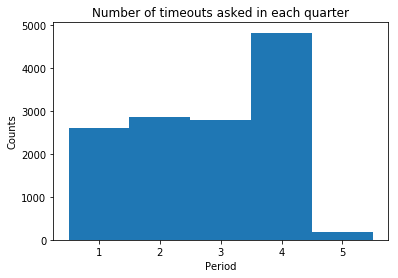

In [9]:
# Interactive plots with a different library that would allow me to keep uising matplotlib to style charts.

# We clip the data so every timeout after the 4th is considered into the same window "OT"
plt.figure()
plt.title('Number of timeouts asked in each quarter')
plt.xlabel('Period')
plt.ylabel('Counts')
plt.xticks(bins + 0.5, range(1, 6))
arr_hist, edges = np.histogram(timeouts['PERIOD'].clip(upper=5), bins=5, range=(1, 6))
plt.hist(timeouts['PERIOD'].clip(upper=5), bins=5, range=(1, 6));


# Define some CSS to control our custom labels
css = """
table
{
  border-collapse: collapse;
}
th
{
  color: #ffffff;
  background-color: #000000;
}
td
{
  background-color: #cccccc;
}
table, th, td
{
  font-family:Arial, Helvetica, sans-serif;
  border: 1px solid black;
  text-align: right;
}
"""

# tooltip = plugins.PointHTMLTooltip(points[0], labels,
#                                    voffset=10, hoffset=10, css=css)
# plugins.connect(fig, tooltip)

# mpld3.show()


- There are virtually double the amount of timeouts during the 4th quarter (as expected). When the games are close, timeouts during the 4th quarter are crucial to draw plays on almost a posession by possesion basis. Because of this I think it might be more productive to separate the 4th from the first three quarters in further analysis.
- These are interesting peaks. However: There must be two timeouts in each quarter. In each quarter, if no team has called a timeout before the 6:59 mark, a timeout is charged to the home team, and if no subsequent timeout is taken prior to the 2:59 mark, a timeout is charged to the team not previously charged with a timeout. The first and second timeouts in each quarter are two minutes 45 seconds for locally televised games, and three minutes 15 seconds for nationally televised games. Other timeouts in a quarter are one minute 15 seconds in length.
- If this last statement is true, these peaks should be biased if we separate between home and away timeouts.



In [ ]:
# Plot timeouts by time left in the quarter and which team asked for it. 
home_timeouts = timeouts.loc[timeouts['HOMEDESCRIPTION'].str.contains("Timeout", na=False)]
away_timeouts = timeouts.loc[timeouts['VISITORDESCRIPTION'].str.contains("Timeout", na=False)]


plt.figure()
plt.title('Number of timeouts asked by time left in quarter')
plt.xlabel('Time left in period')
plt.ylabel('Counts')
plt.xticks(np.linspace(0, 720, num=13), range(0, 13))

plt.hist(away_timeouts['PCTIMESTRING'], bins= 96)
plt.hist(home_timeouts['PCTIMESTRING'], bins= 96, alpha=0.7);


Like we mentioned before, there are many more timeouts in the 4th quarter and if you watch basketball you understand that 4th quarter timeouts are fundamentally different from the ones taken before.

In [ ]:
# Let's filter timeout times by period.
plt.figure()
plt.title('Number of timeouts asked by time left in the quarter')
plt.xlabel('Time left in period')
plt.ylabel('Counts')
#plt.xticks(np.linspace(0, 720, num=13), range(0, 13))


temp1 = timeouts.query('PERIOD == 1')
temp2 = timeouts.query('PERIOD == 2')
temp3 = timeouts.query('PERIOD == 3')
temp4 = timeouts.query('PERIOD >= 4')

plt.hist(temp3['PCTIMESTRING'], bins= 96);



- Don't forget to make a subplot figure out of each quarter distribution.
- What we can observe is that the shapes are similar for periods 1 thru 3 and significantly different for the 4th.
- This suggest we should approach any analysis separately.

# Scores surrouding timeouts
- If we want to look at scoring effects surrounding timeouts.
- First let's look at just the absolute score margins when the home/away teams call for timeout.

In [ ]:
home_timeout_margins = home_timeouts['SCOREMARGIN']
away_timeout_margins = away_timeouts['SCOREMARGIN']


plt.figure()
plt.title('Score differential at the timeout')
plt.xlabel('Point difference (+home, -away)')
plt.ylabel('Counts')
plt.hist(home_timeouts['SCOREMARGIN'], bins=50, range=(-25, 25))
plt.hist(away_timeouts['SCOREMARGIN'], bins=50, range=(-25, 25));

plt.figure()
plt.title('Score differential at the timeout')
plt.xlabel('Point difference (+win, -lose)')
plt.ylabel('Counts')

# Here we used concat because we wanted to multiply the away timeouts only and then use the hometimeouts.
plt.hist(pd.concat([home_timeouts['SCOREMARGIN'], away_timeouts['SCOREMARGIN']*-1]), bins=50, range=(-25, 25));

- Those twin peaks are quite interesting. They are both slightly shifted from zero but in opposite directions. 
- If we take the absolute score differential for only the away team, we can pool all the timeouts together.
- That reveals a more obvious shift to the negative side. This means that most timeouts are asked when losing. Also, nothing new here, but it is a nice confirmation.

- This could be another source of separating data for more analysis (for example, take only timeouts when it was a single digit game.

# Timeout-triggered averages
- One of our main goals was to look at the evolution of the score in a variable window of time around a timeout.
- This means that we need to slice pieces of data based on when timeouts happen. 
- To me, as of right now, the best way seems to be creating a function that takes in specific indices of events (in this case timeouts) and returns the whatever desired data we want in a window of interest.

In [ ]:
# Okay so apparently this function takes in data, the location (by index) of and event in the data and a window in seconds.
# Returns a selection of the data leading up to that event based on the window provided.

def select_window(data, location, window):
    
    # our window is gonna be by time in seconds
    # but for each event there might not be enough window for before and after
    # in those cases, we will take until the start or end of the quarter.
    
    time_left = data.loc[location, 'PCTIMESTRING']
    
    # we will calculate a lower limit but for now only look at the time leading up to a timeout (before)
    if time_left - window < 0:
        lower = 0
    else:
        lower = time_left - window
        
    
    if time_left + window > 720:
        upper = 720
    else:
        upper = time_left + window
        
    data['TIMERELATIVE'] = (data['PCTIMESTRING'] - time_left)*-1
    
    selection = data[(data['GAME_ID'] == data.loc[location, 'GAME_ID']) & (data['PERIOD'] == data.loc[location, 'PERIOD']) & (data['PCTIMESTRING'] >= lower) & (data['PCTIMESTRING'] <= upper)]
    
    return selection

    


In [ ]:
# Before we generalize too much! Let's just make one function to get us a plot of DELTAMARGIN around a window.

window = 90

score_margin = []
start_margin = []
timeout_margin = []
end_margin = []
time_to_timeout = []

indices = home_timeouts.query('PERIOD < 4').index.values
print(len(indices))
print(indices)


for x in indices:
    
    selection = select_window(data, x, window)        
    start_margin.append(selection['SCOREMARGIN'].iloc[0])
    end_margin.append(selection['SCOREMARGIN'].iloc[-1])
    margin = selection['SCOREMARGIN'] - selection['SCOREMARGIN'].iloc[0]
    time_to_timeout.extend(list(selection['TIMERELATIVE']))
    score_margin.extend(list(margin))
    
    
        
        

In [ ]:
binned_avg = stats.binned_statistic(time_to_timeout, score_margin, statistic='mean', bins= window*2)
binned_stdev = stats.binned_statistic(time_to_timeout, score_margin, statistic='std', bins= window*2)

plt.figure()
plt.xlabel('Time (s)')
plt.ylabel('Score Margin')
# plt.fill_between(range(window*2), binned_avg[0] - binned_stdev[0], binned_avg[0] + binned_stdev[0])
plt.plot(binned_avg[0], lw= 2, c='k');

# OMG.
- This will beatufully fit exponential functions.
- I also think timeouts taken in between free throws are introducting the big jumps in the middle. You should totally quantify this.
- But now I don't know anymore. I think it's something different now. I think that aligning data to the timeout also aligns posessions at that time point. This means that usually the opposing team scored, then team calls timeout, then the ball is theirs, with a plan. That's what I think
- I don't think so.

In [ ]:
data.dtypes

- Out of curiosity I want to see the change in score diff?

In [ ]:
plt.figure()
plt.title('Score differential at the timeout')
plt.xlabel('Point difference (+home, -away)')
plt.ylabel('Counts')
plt.hist(away_timeouts['SCOREMARGIN'], bins=80, range=(-40, 40))
plt.hist(end_margin, bins=80, range=(-40, 40), alpha=0.6);

diff1 = away_timeouts['SCOREMARGIN'] - start_margin
diff2 = end_margin - away_timeouts['SCOREMARGIN']
print(len(diff1))

plt.figure()
plt.title('Score differential at the timeout')
plt.xlabel('Change in score margin')
plt.ylabel('Counts')
plt.hist(diff1, bins=20, range=(-10, 10))
plt.hist(diff2, bins=20, range=(-10, 10), alpha=.8);




- This last plot is interesting. There is a shignificant shift rightward suggesting, for now, that timeouts indeed do generally help.
- One thing I could do next is look at which are the timeouts that were most succesful and look at their past?
